## 1 - Keras入门 - 笑脸识别

In [1]:
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# from tensorflow.keras.utils import layer_utils
from tensorflow.python.keras.utils import layer_utils
# from tensorflow.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.data_utils import get_file

from tensorflow.keras.applications.imagenet_utils import preprocess_input

import pydot
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils import plot_model
import kt_utils

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = kt_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print("number of training examples = {}".format(X_train.shape[0]))
print("number of test examples = {}".format(X_test.shape[0]))
print("X_train shape: {}".format(X_train.shape))
print("Y_train shape: {}".format(Y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("Y_test shape: {}".format(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


In [3]:
def HappyModel(input_shape):
    """
    实现一个检测笑容的模型

    Args:
        input_shape: 输入数据的维度

    Returns:
        model 创建的Keras模型

    """
    X_input = Input(shape=input_shape)

    # 使用0填充：X_input的周围填充0
    X = ZeroPadding2D((3, 3))(X_input)

    # 对X使用CONV -> BN -> RELU块
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation("relu")(X)

    # 最大池化层
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # 降维，矩阵转化为向量 + 全链接层
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # 创建模型，创建一个模型的实体，可以用它来训练、测试。
    model = Model(inputs=X_input, outputs=X, name='HappyModel')

    return model

In [4]:
# 创建一个模型实例
happy_model = HappyModel(X_train.shape[1:])
# 编译模型
happy_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 训练模型
happy_model.fit(x=X_train, y=Y_train, epochs=40, batch_size=64)
# 评估模型
preds = happy_model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None)

print("误差值 = {}".format(preds[0]))
print("准确度 = {}".format(preds[1]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 600 samples
Epoch 1/40
600/600 [==============================] - 4s 7ms/sample - loss: 0.8845 - acc: 0.6650
Epoch 2/40
600/600 [==============================] - 0s 327us/sample - loss: 0.2567 - acc: 0.8783
Epoch 3/40
600/600 [==============================] - 0s 319us/samp

[[1.]]


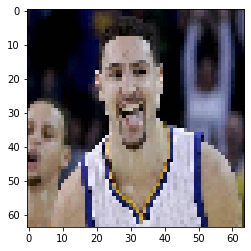

In [5]:
# 测试你的图片
img = image.load_img('./klay.jpg', target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happy_model.predict(x=x))

In [7]:
happy_model.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0


----
2 - 残差网络的搭建

In [8]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file

from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform


import pydot
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import resnets_utils

In [9]:
def identity_block(X, f, filters, stage, block):
    """
    实现恒等块
    Args:
        X: 输入的tensor类型的数据，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        f: 整数，指定主路径中间的CONV窗口的维度
        filters: 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage: 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block: 字符串，据每层的位置来命名每一层，与stage参数一起使用。

    Returns:
        X - 恒等块的输出，tensor类型，维度为(n_H, n_W, n_C)
    """

    # 定义命名规则
    conv_name_base = "res{}{}_branch".format(stage,block)
    bn_name_base = "bn{}{}_branch".format(stage,block)

    # 获取过滤器数量
    F1, F2, F3 = filters

    # 保存输入数据，将会用于为主路径添加捷径
    X_shortcut = X

    # 主路径：1st part
    ## conv layer
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    ## BN layer
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    ## ReLU
    X = Activation('relu')(X)

    # 主路径：2nd part
    ## conv layer
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    ## BN layer
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    ## ReLU
    X = Activation('relu')(X)

    # 主路径：3rd part
    ## conv layer
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    ## BN layer
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    ## no ReLU

    # Finally
    ## 将捷径与输入加在一起
    X = Add()([X, X_shortcut])
    ## ReLU
    X = Activation('relu')(X)

    return X

In [13]:
tf.reset_default_graph()
with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder('float', shape=(3, 4, 4, 6))
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block='a')

    init = tf.global_variables_initializer()
    test.run(init)
    out = test.run([A], feed_dict={A_prev: X,
                                   K.learning_phase(): 0})
    print("out = {}".format(out[0][1][1][0]))
    print(out[0].shape)
    test.close()

out = [0.9482299 0.        1.1610144 2.747859  0.        1.36677  ]
(3, 4, 4, 6)


**我们已经实现了残差网络的恒等块，现在，残差网络的卷积块是另一种类型的残差块，
它适用于输入输出的维度不一致的情况，它不同于上面的恒等块，与之区别在于，
捷径中有一个CONV2D层**

In [14]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    实现卷积块
    Args:
        X: 输入的tensor类型的变量，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        f: 整数，指定主路径中间的CONV窗口的维度
        filters: 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage: 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block: 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        s: 整数，指定要使用的步幅

    Returns:
        X - 卷积块的输出，tensor类型，维度为(n_H, n_W, n_C)
    """

    # 定义命名规则
    conv_name_base = "res{}{}_branch".format(stage,block)
    bn_name_base = "bn{}{}_branch".format(stage,block)

    # 获取过滤器数量
    F1, F2, F3 = filters

    # 保存输入数据，将会用于为主路径添加捷径
    X_shortcut = X

    # 主路径：1st part
    ## conv layer
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    ## BN layer
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    ## ReLU
    X = Activation('relu')(X)

    # 主路径：2nd part
    ## conv layer
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    ## BN layer
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    ## ReLU
    X = Activation('relu')(X)

    # 主路径：3rd part
    ## conv layer
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    ## BN layer
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    ## no ReLU

    # 捷径
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid',
                        name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Finally
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)

    A = convolutional_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block="a")
    test.run(tf.global_variables_initializer())

    out = test.run([A],feed_dict={A_prev: X,
                                  K.learning_phase(): 0})
    print("out = {}".format(out[0][1][1][0]))
    print(out[0].shape)
    test.close()

out = [0.09018461 1.2348977  0.46822017 0.0367176  0.         0.655166  ]
(3, 2, 2, 6)


In [17]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    实现ResNet50
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Args:
        input_shape: 图像数据集的维度
        classes: int，分类数

    Returns:
        model - Keras框架的模型
    """

    # 定义tensor类型的输入数据
    X_input = Input(input_shape)

    #0填充
    X = ZeroPadding2D((3, 3))(X_input)

    # stage1
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)

    # stage2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block="a", s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block="c")

    # stage3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block="a", s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block="b")
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block="c")
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block="d")

    # stage4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block="a", s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="b")
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="c")
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="d")
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="e")
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block="f")

    # stage5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block="a", s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block="c")

    #输出层
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc"+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)

    #创建模型
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model

In [18]:
model = ResNet50(input_shape=(64, 64, 3), classes=6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = resnets_utils.load_dataset()
# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = resnets_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = resnets_utils.convert_to_one_hot(Y_test_orig, 6).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [20]:
model.fit(X_train, Y_train, epochs=2, batch_size=32)

Train on 1080 samples
Epoch 1/2
1080/1080 [==============================] - 10s 9ms/sample - loss: 5.0694 - acc: 0.2583

In [21]:
preds = model.evaluate(X_test, Y_test)

print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

120/120 [==============================] - 1s 11ms/sample - loss: 2.1325 - acc: 0.1667
误差值 = 2.1324776728947956
准确率 = 0.16666667


In [26]:
#加载模型
model = load_model("./ResNet50.h5")

AttributeError: 'str' object has no attribute 'decode'

In [27]:
preds = model.evaluate(X_test, Y_test)
print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

120/120 [==============================] - 0s 1ms/sample - loss: 2.1325 - acc: 0.1667
误差值 = 2.1324776728947956
准确率 = 0.16666667


In [28]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________